In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.sparse.linalg import lsqr
from scipy.signal import savgol_filter, general_gaussian
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.patches as patches
from collections import OrderedDict 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec


In [63]:
def asc_to_dataframe(filename):
    # Find the index of the row that starts with "Time[ns]  No_of_photons"
    start_index = 0
    end_index = 0
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if "Date and Time" in line:
                end_index = i
                break

    data = pd.read_csv(filename, sep = '\t', skiprows=start_index, skipfooter = open(filename).read().count('\n') - end_index, engine='python') 
    # Give name to first column
    data = data.rename(columns={data.columns[0]: 'Raman Shift [cm^-1]'})
    # Renae the second column
    data = data.rename(columns={data.columns[1]: 'Counts'})
    return pd.DataFrame(data)
def create_dataframe_list(directory, file_startswith):
    dataframe_list = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.startswith(file_startswith) and filename.endswith(".asc"):
            df = asc_to_dataframe(os.path.join(directory, filename))
            df = df_cut_df(df, 0, len(df))
            dataframe_list.append(df)
            
            filenames.append(filename)
    return dataframe_list, filenames

def df_cut_df(df, start = None, end = None):
    if start == None:
        start = 0
    if end == None:
        end = len(df)
    mask = (df['Raman Shift [cm^-1]'] >= start) & (df['Raman Shift [cm^-1]'] <= end)
    #reset the index
    return df.loc[mask].reset_index(drop=True)

def plot_raman(df):
    plt.plot(df['Raman Shift [cm^-1]'], df['Counts'])
    plt.xlabel('Raman Shift [cm^-1]')
    plt.ylabel('Counts')
    plt.show()
    
def remove_background(df_API, df_back):
    df_API_copy = df_API.copy()
    df_API_copy['Counts'] = df_API['Counts'] - df_back['Counts']
    return df_API_copy

def normalize_df(df, range_min, range_max):
    df_copy = df.copy()
    mask = (df_copy['Raman Shift [cm^-1]'] >= range_min) & (df_copy['Raman Shift [cm^-1]'] <= range_max)
    df_copy['Counts'] = df_copy['Counts']*1000000/df_copy.loc[mask, 'Counts'].sum()
    return df_copy

def shift_to_0(df):
    df_copy = df.copy()
    df_copy['Counts'] = df['Counts'] - min(df['Counts'])
    return df_copy



In [41]:
df_API_list, filenames_API = create_dataframe_list("data", "API")
df_back_list, filenames_back = create_dataframe_list("data", "Back")
df_C1_list, filenames_C1 = create_dataframe_list("data", "C1")
df_C2_list, filenames_C2 = create_dataframe_list("data", "C2")
df_C3_list, filenames_C3 = create_dataframe_list("data", "C3")
df_test = df_cut_df(df_API_list[0], 400, 2000)

# Cut the dataframes
df_API_list = [df_cut_df(df, 400, 2000) for df in df_API_list]
df_back_list = [df_cut_df(df, 400, 2000) for df in df_back_list]
df_C1_list = [df_cut_df(df, 400, 2000) for df in df_C1_list]
df_C2_list = [df_cut_df(df, 400, 2000) for df in df_C2_list]
df_C3_list = [df_cut_df(df, 400, 2000) for df in df_C3_list]


# Data Pre-Processing


## Despiking Raman Spectra

In [36]:
# Depicking spectrum
# The next function calculates the modified z-scores of a diferentiated spectrum
def despike_spectrum(df, ma, threshould = 7, make_plots = False):
    def modified_z_score(ys):
        ysb = np.diff(ys) # Differentiated intensity values
        median_y = np.median(ysb) # Median of the intensity values
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
        return modified_z_scores
        
    # The next function calculates the average values around the point to be replaced.
    def fixer(y, ma, threshold):
        spikes = abs(np.array(modified_z_score(y))) > threshold
        print("Spikes found: ", sum(spikes))
        y_out = y.copy()
        for i in np.arange(len(spikes)):
            if spikes[i] != 0:
                # w = np.arange(max(0, i-ma), min(len(y), i+1+ma))
                w = np.arange(max(0, i-ma), min(len(y)-1, i+ma))
                we = w[spikes[w] == 0]
                y_out[i] = np.mean(y[we])
        return y_out
    def plot_fixer(wavelength, intensity):
        # Does it work?
        plt.plot(wavelength, intensity, label = 'original data')
        plt.plot(wavelength, fixer(intensity,ma, threshould), label = 'Despiked data')
        plt.title('Despiked spectrum',fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel('Wavelength (nm)' ,fontsize = 20)
        plt.ylabel('Intensity (a.u.)' ,fontsize = 20)
        plt.legend()
        plt.show()
    
    def plot_z_score(wavelength, intensity):
        wavelength = wavelength[:-1]
        intensity_modified_z_score = np.array([abs(x) for x in modified_z_score(intensity)])
        plt.plot(wavelength, intensity_modified_z_score)
        plt.plot(wavelength, threshould*np.ones(len(wavelength)), label = 'threshold = ' + str(threshould), linestyle = '--')
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.legend()
        plt.xlabel('Wavelength (nm)' ,fontsize = 20)
        plt.ylabel('|Modified Z-Score|' ,fontsize = 20)
        plt.show()
    mix_spectrum = df['Counts']
    despiked_spectrum = fixer(mix_spectrum,ma=ma, threshold=threshould)

    df_despiked = df.copy()
    df_despiked['Counts'] = despiked_spectrum
    if make_plots:
        plot_z_score(df['Raman Shift [cm^-1]'], df['Counts'])
        plot_fixer(df['Raman Shift [cm^-1]'], despiked_spectrum)
    return df_despiked



Spikes found:  121
Spikes found:  130
Spikes found:  124
Spikes found:  123
Spikes found:  139
Spikes found:  136
Spikes found:  151
Spikes found:  136
Spikes found:  121
Spikes found:  137
Spikes found:  118
Spikes found:  126
Spikes found:  122
Spikes found:  104
Spikes found:  148
Spikes found:  140
Spikes found:  121
Spikes found:  138
Spikes found:  124
Spikes found:  140
Spikes found:  133
Spikes found:  107
Spikes found:  119
Spikes found:  148
Spikes found:  131
Spikes found:  149
Spikes found:  150
Spikes found:  139
Spikes found:  158
Spikes found:  159
Spikes found:  146
Spikes found:  134
Spikes found:  128
Spikes found:  127
Spikes found:  152
Spikes found:  134
Spikes found:  124
Spikes found:  131
Spikes found:  104
Spikes found:  116
Spikes found:  133
Spikes found:  111
Spikes found:  125
Spikes found:  130
Spikes found:  137
Spikes found:  117
Spikes found:  136
Spikes found:  133
Spikes found:  127
Spikes found:  125
Spikes found:  132
Spikes found:  136
Spikes found

In [42]:
df_API_despiked_list = []
for i in range(len(df_API_list)):
    df_API_despiked_list.append(despike_spectrum(df_API_list[i], 20, 1.5, make_plots = False))
    
df_back_despiked_list = []
for i in range(len(df_back_list)):
    df_back_despiked_list.append(despike_spectrum(df_back_list[i], 20, 1.5, make_plots = False))

df_C1_despiked_list = []
for i in range(len(df_C1_list)):
    df_C1_despiked_list.append(despike_spectrum(df_C1_list[i], 20, 1.5, make_plots = False))
    
df_C2_despiked_list = []
for i in range(len(df_C2_list)):
    df_C2_despiked_list.append(despike_spectrum(df_C2_list[i], 20, 1.5, make_plots = False))
    
df_C3_despiked_list = []
for i in range(len(df_C3_list)):
    df_C3_despiked_list.append(despike_spectrum(df_C3_list[i], 20, 1.5, make_plots = False))

Spikes found:  111
Spikes found:  118
Spikes found:  125
Spikes found:  117
Spikes found:  121
Spikes found:  119
Spikes found:  135
Spikes found:  135
Spikes found:  105
Spikes found:  142
Spikes found:  105
Spikes found:  124
Spikes found:  119
Spikes found:  116
Spikes found:  126
Spikes found:  122
Spikes found:  114
Spikes found:  119
Spikes found:  92
Spikes found:  123
Spikes found:  114
Spikes found:  108
Spikes found:  108
Spikes found:  128
Spikes found:  125
Spikes found:  136
Spikes found:  126
Spikes found:  121
Spikes found:  146
Spikes found:  138
Spikes found:  138
Spikes found:  122
Spikes found:  119
Spikes found:  134
Spikes found:  140
Spikes found:  128
Spikes found:  115
Spikes found:  115
Spikes found:  109
Spikes found:  112
Spikes found:  129
Spikes found:  111
Spikes found:  127
Spikes found:  113
Spikes found:  122
Spikes found:  97
Spikes found:  119
Spikes found:  129
Spikes found:  123
Spikes found:  131
Spikes found:  137
Spikes found:  126
Spikes found: 

## Baseline Separation

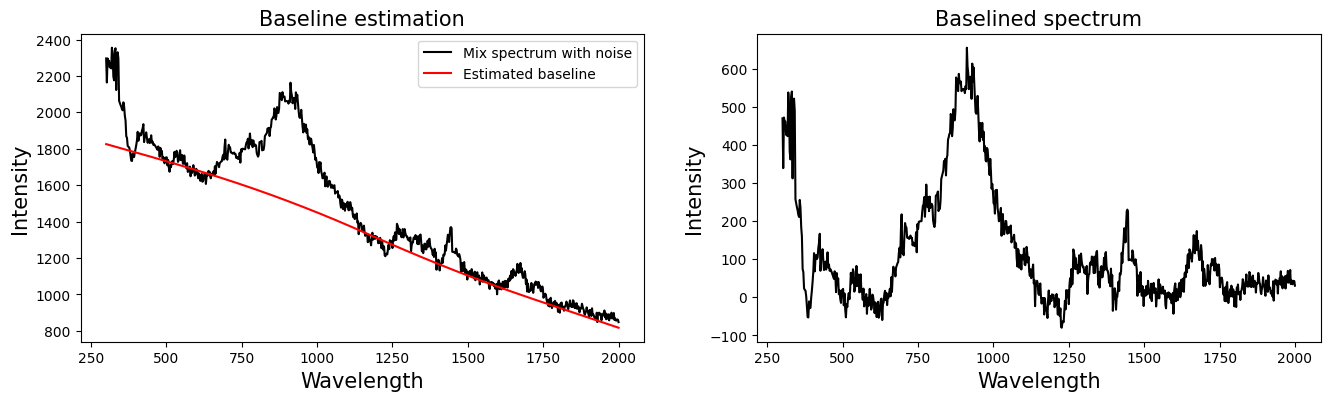

In [21]:
# Baseline estimation with asymmetric least squares
# According to paper: "Baseline Correction with Asymmetric Least Squares Smoothing" 
# by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005

# Baseline stimation function:

def baseline_estimation(df, lam = 10000000, p = 0.05, niter=3, make_plots = False):
    def baseline_als(y, lam, p, niter=3):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
        w = np.ones(L)
        W = sparse.spdiags(w, 0, L, L)
        for i in range(niter):
            W.setdiag(w) # Do not create a new matrix, just update diagonal values
            Z = W + D
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z

    despiked_spectrum = df['Counts']
    estimated_baselined = baseline_als(despiked_spectrum, lam, p)

    baselined_spectrum = despiked_spectrum - estimated_baselined
    if make_plots:
        # How does it look like?
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
        x_range = df['Raman Shift [cm^-1]']
        # We compared the original mix spectrum and the estimated baseline:
        ax1.plot(x_range, despiked_spectrum, color = 'black', label = 'Mix spectrum with noise' )
        ax1.plot(x_range, estimated_baselined, color = 'red', label = 'Estimated baseline')
        ax1.set_title('Baseline estimation', fontsize = 15)
        ax1.set_xlabel('Wavelength', fontsize = 15)
        ax1.set_ylabel('Intensity',  fontsize = 15)
        ax1.legend()

        # We plot the mix spectrum after baseline subtraction
        ax2.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
        ax2.set_title('Baselined spectrum', fontsize = 15)
        ax2.set_xlabel('Wavelength', fontsize = 15)
        ax2.set_ylabel('Intensity',  fontsize = 15)
        plt.show()
    df_baselined = df.copy()
    df_baselined['Counts'] = baselined_spectrum
    return df_baselined



In [ ]:
df_API_baselined_list = []
for i in range(len(df_API_despiked_list)):
    print("Baseline estimation API spectrum number: ", i)
    df_API_baselined_list.append(baseline_estimation(df_API_despiked_list[i], lam = 10000000, p = 0.0, niter=20, make_plots = False))
    
df_back_baselined_list = []
for i in range(len(df_back_list)):
    df_back_baselined_list.append(baseline_estimation(df_back_list[i], lam = 10000000, p = 0.0, niter=20, make_plots = False))
    
df_C1_baselined_list = []
for i in range(len(df_C1_list)):
    df_C1_baselined_list.append(baseline_estimation(df_C1_despiked_list[i], lam = 10000000, p = 0.0, niter=20, make_plots = False))
    
df_C2_baselined_list = []
for i in range(len(df_C2_list)):
    df_C2_baselined_list.append(baseline_estimation(df_C2_despiked_list[i], lam = 10000000, p = 0.0, niter=20, make_plots = False))
    
df_C3_baselined_list = []
for i in range(len(df_C3_list)):
    df_C3_baselined_list.append(baseline_estimation(df_C3_despiked_list[i], lam = 10000000, p = 0.0, niter=20, make_plots = False))

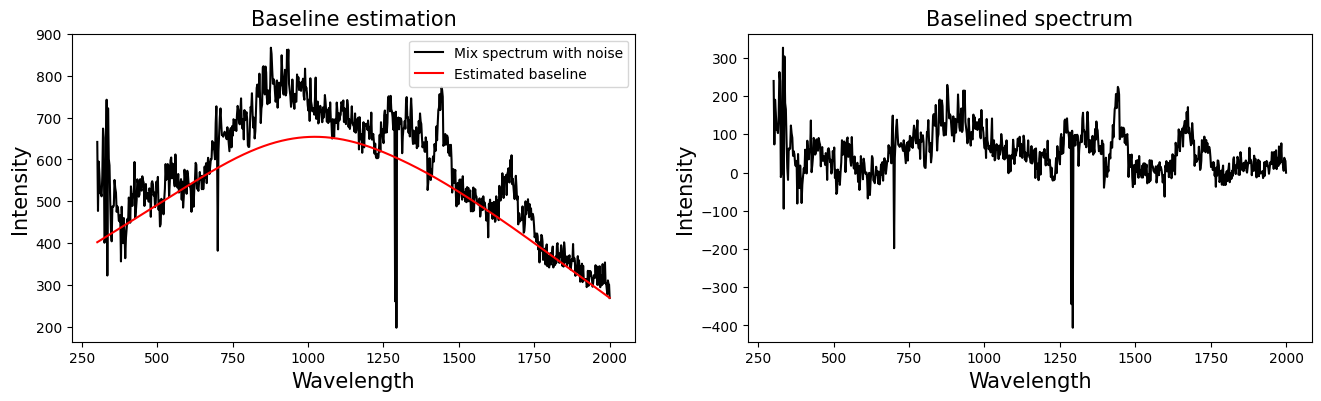

In [809]:
df_API_no_background_baselined = baseline_estimation(df_API_no_background, lam = 10000000, p = 0.05, niter=5, make_plots = True)

## Smoothing

In [43]:
def smoothing_spectrum(df, window_length = 11, polyorder = 2, make_plots = False):
    def plot_smoothed_spectrum(wavelength, intensity, smoothed_intensity):
        plt.plot(wavelength, intensity, label = 'original data')
        plt.plot(wavelength, smoothed_intensity, label = 'Smoothed data')
        plt.title('Smoothed spectrum',fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel('Wavelength' ,fontsize = 20)
        plt.ylabel('Intensity' ,fontsize = 20)
        plt.legend()
        plt.show()
    smoothed_spectrum = savgol_filter(df['Counts'], window_length = window_length, polyorder = polyorder)
    if make_plots:
        plot_smoothed_spectrum(df['Raman Shift [cm^-1]'], df['Counts'], smoothed_spectrum)
    df_smoothed = df.copy()
    df_smoothed['Counts'] = smoothed_spectrum
    return df_smoothed


df_API_smoothed_list = []
for i in range(len(df_API_despiked_list)):
    df_API_smoothed_list.append(smoothing_spectrum(df_API_despiked_list[i], window_length = 11, polyorder = 2, make_plots = False))
    
df_back_smoothed_list = []
for i in range(len(df_back_despiked_list)):
    df_back_smoothed_list.append(smoothing_spectrum(df_back_despiked_list[i], window_length = 11, polyorder = 2, make_plots = False))
    

Smoothing API spectrum number:  0
Smoothing API spectrum number:  1
Smoothing API spectrum number:  2
Smoothing API spectrum number:  3
Smoothing API spectrum number:  4
Smoothing API spectrum number:  5
Smoothing API spectrum number:  6
Smoothing API spectrum number:  7
Smoothing API spectrum number:  8
Smoothing API spectrum number:  9


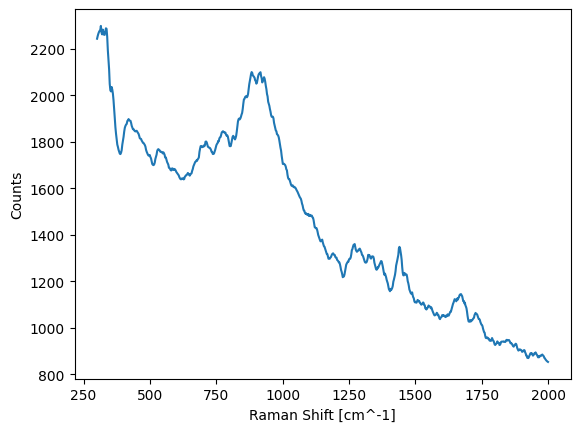

In [40]:
plot_raman(df_API_smoothed_list[0])

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_6049/2434571238.py:86: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(xs, fit, 'r-', label='Fit', c='red', lw=2, ls='--')
/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_6049/2434571238.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(xs, fit, 'r-', label='Fit', c='red', lw=2, ls='--')


n_peaks:  [[1850.8625      207.9484356 ]
 [1992.1575      214.35365891]
 [1556.2489      236.46104638]
 [ 473.87961     286.28560598]
 [ 987.69043     350.30228895]
 [ 543.90631     357.53992394]
 [ 838.61102     363.16818132]
 [ 707.37781     372.40689428]
 [1674.6127      407.24997944]
 [1138.4685      468.91587974]
 [1267.3625      552.87192978]
 [1440.2701      625.41849984]]


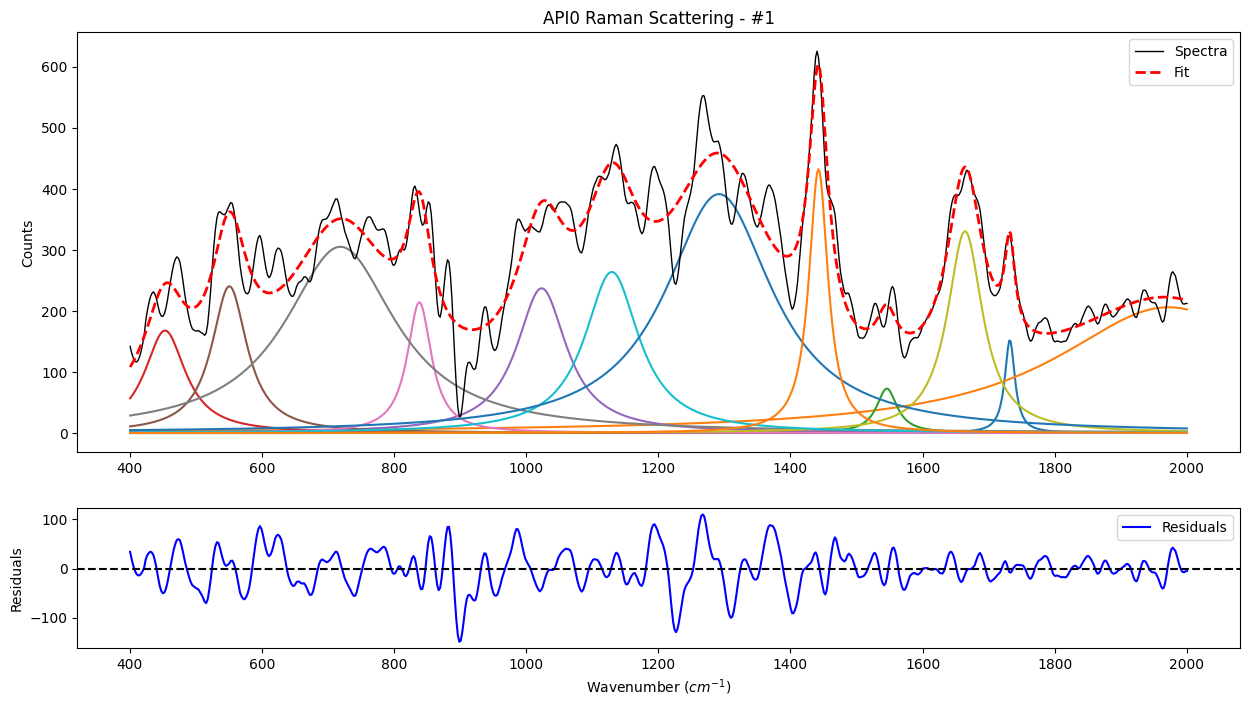

In [102]:

def fit_lorentzians(df, n_peaks_to_find=5):

    def predict_and_plot_lorentzians(xs, ys, n_peaks_to_find=5):

        n_peaks = np.asarray(get_highest_n_peaks_scipy(xs, ys, n_peaks_to_find))

        guess = []

        for idx, xs_ys in enumerate(n_peaks):
            guess.append(xs_ys[0]) #ctr
            guess.append(xs_ys[1]) #amp
            guess.append(10) #width ###This could be improved by estimating the width first for a better fit


        params, fit = fit_lorentzians(guess, func, xs, ys) ###params is the array of gaussian stuff, fit is the y's of lorentzians
        
        
        return (params, fit, ys, n_peaks)
    def fit_lorentzians(guess, func, x, y):
        # Uses scipy curve_fit to optimise the lorentzian fitting
        sigma = [2] * len(y)
        popt, pcov = curve_fit(func, x, y, p0=guess, maxfev=140000, sigma=sigma)
        fit = func(x, *popt)
        # Plot the fit
        # plt.plot(x, fit, 'r-')
        return (popt, fit)
        # pyplot.show()
    def func(x, *params):
        ''' *params of the form [center, amplitude, width ...] '''
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            ctr = params[i]
            amp = params[i+1]
            wid = params[i+2]
            # y = y + amp * np.exp( -((x - ctr)/wid)**2)
            y = y + lorentzian(x, amp, ctr, wid)
        return y
    def find_peaks_scipy(xs, ys, widths=np.arange(1,50, 0.5)):
        peaks = scipy.signal.find_peaks_cwt(ys, widths) #Problem
        # plt.plot(xs[peaks], ys[peaks], ls='', marker='o', markersize=20, color = 'Green', alpha=0.5)

        # plt.plot(xs, ys)
        # print('*************PEAKSCIPY**************')
        # print('From scipy: \nPeak_pos= ', peaks, '\nPeaks= ', xs[peaks], '\nIntensities= ',ys[peaks])
        # print('************************************')

        return peaks 
    
    def lorentzian(x, amp, ctr, wid):
        return amp*wid**2/((x-ctr)**2+wid**2)
    def get_highest_n_from_list(a, n):
        # Returns the highest peaks found by the peak finding algorithms
        return sorted(a, key=lambda pair: pair[1])[-n:]
    def import_data(df_list):
        dict_container = OrderedDict()
        for i, df in enumerate(df_list):
            # Convert DataFrame to numpy array and add to dict_container
            dict_container[i] = [df[['Raman Shift [cm^-1]', 'Counts']].to_numpy()]
        return dict_container
    def get_highest_n_peaks_scipy(xs, ys, n, th=0.25):
        smooth_indexes_scipy = find_peaks_scipy(xs, ys)
        ##take the highest 'n' smooth peaks 
        peak_indexes_xs_ys = np.asarray([list(a) for a in list(zip(xs[smooth_indexes_scipy], ys[smooth_indexes_scipy]))])
        return get_highest_n_from_list(peak_indexes_xs_ys, n)
    dict_container = import_data([df])

    ###THIS CODE GOES THROUGH ALL THE DATA 
    for sample_id, sample_data in dict_container.items():
        for idx, data_set in enumerate(sample_data):
            xs = data_set[:,0]
            ys = data_set[:,1]
            # data_set[:,1] = 9.5*data_set[:,1]/np.max(data_set[:,1])

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), gridspec_kw={'height_ratios': [3, 1]}) # Create two subplots: one for the main plot and one for residuals

            ax1.set_title("API" + str(sample_id) + " Raman Scattering - #" + str(idx+1))

            try:
                params, fit, ys, n_peaks = predict_and_plot_lorentzians(xs,ys, n_peaks_to_find) # 5 = number of peaks to fit to ##Returns modified ys for y axis scaling
                for j in range(0, len(params), 3): 
                    ctr = params[j] 
                    amp = params[j+1]
                    width = params[j+2]
                    ax1.plot(xs, lorentzian(xs, amp, ctr, width), ls='-')
                ax1.plot(xs,ys, lw=1, label='Spectra', c='black')
                ax1.plot(xs, fit, 'r-', label='Fit', c='red', lw=2, ls='--')
                # Plot vertical grey dashed line on each peak
                # for peak in n_peaks:
                #     ax1.axvline(peak[0], color='grey', linestyle='--', alpha=0.5)
                #     # Type horizontal value next to peak on the top
                #     ax1.text(peak[0]-30, max(ys), str(int(peak[1])), rotation=90, fontsize=8)
                
                ax1.legend()
                ax1.set_ylabel("Counts")

                residuals = ys - fit
                ax2.plot(xs, residuals, label='Residuals', c='blue')
                ax2.axhline(0, color='black', linestyle='--') # Add a horizontal line at y=0 to indicate no residuals
                ax2.legend()
                ax2.set_xlabel("Wavenumber ($cm^{-1}$)")
                ax2.set_ylabel("Residuals")

                
            except RuntimeError:
                print(traceback.format_exc())
                ax1.plot(xs,ys, lw=1, label='data- no fit found', c='black')
                ax1.legend()
                ax1.set_ylabel("Counts")

            print('n_peaks: ', n_peaks)
    plt.show()
fit_lorentzians(df_API_0, n_peaks_to_find=50) 

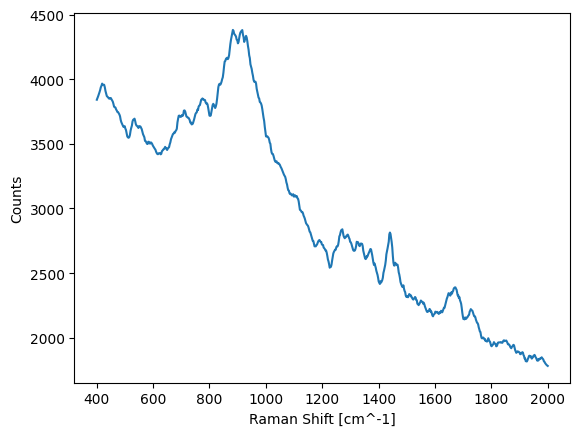

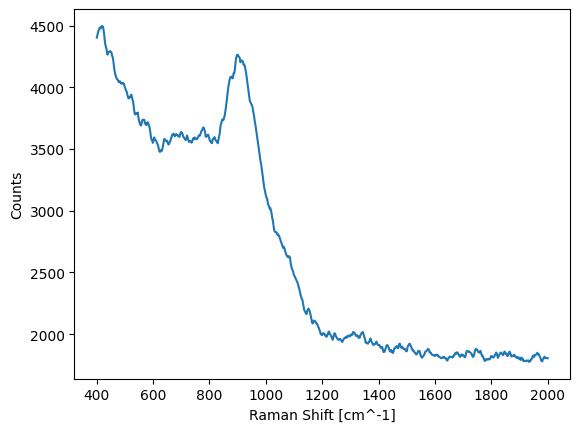

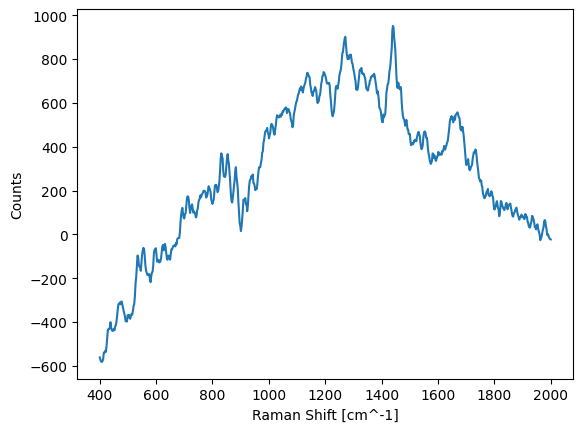

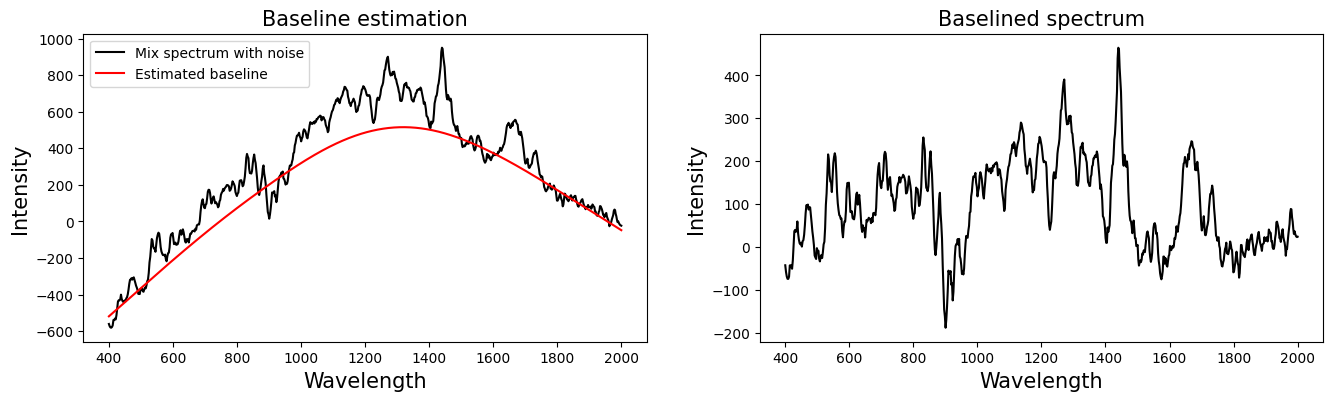

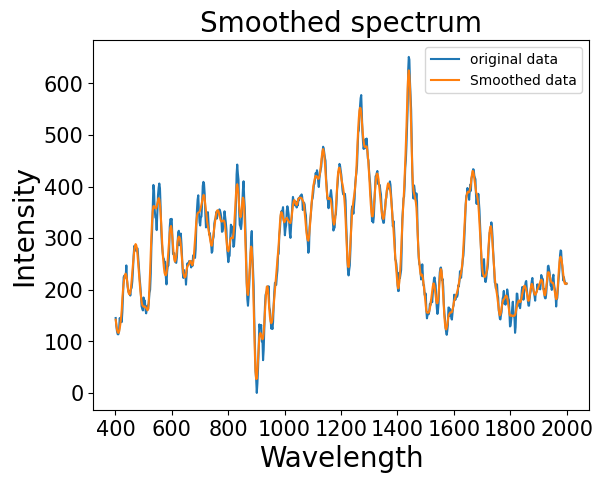

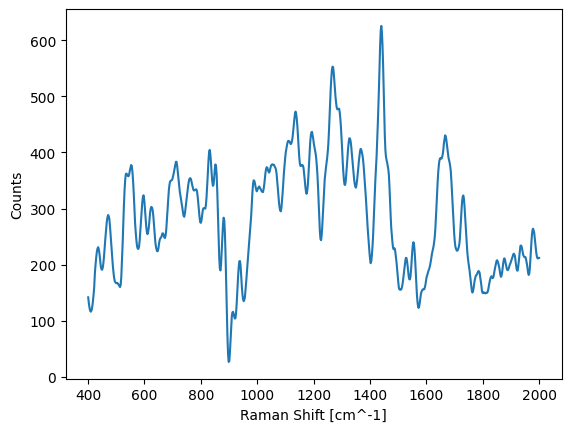

In [101]:




df_API_normalized = normalize_df(df_API_smoothed_list[0], 0, 1000)
df_back_normalized = normalize_df(df_back_smoothed_list[1], 0, 1000)
plot_raman(df_API_normalized)
plot_raman(df_back_normalized)

df_API_no_background = remove_background(df_API_normalized, df_back_normalized)
plot_raman(df_API_no_background)
df_API_no_background_baselined = baseline_estimation(df_API_no_background, lam = 10000000, p = 0.05, niter=5, make_plots = True)
df_API_0 = shift_to_0(df_API_no_background_baselined)

df_API_0 = smoothing_spectrum(df_API_0, window_length = 20, polyorder = 5, make_plots = True)
plot_raman(df_API_0)